# **[exercise 4]** Operational Energy System Optimization
In this notebook we want to **use mathematical modelling** to derive a strategy for an electricity generation company. For this, we are using an optimization approach.

Thereby we will cover the following skills:
- [x] Mathematical modelling
- [x] Optimization

In [89]:
%%capture
%run installation.py
!conda install -c conda-forge glpk -y

In [90]:
import numpy as np
import pandas as pd

## Task 4 : Setting up an optimization problem

Mathematical optimization is a broad term describing a way of mathematically describing decision problems and then solving them using dedicated algorithms. Optimization models consist of three parts:

- the decision variables, which correspond to actions or choices that we can make in our decision problem: whether to open a new manufacturing facility, which supply routes to use, or for which prices we should sell our products.

- the objective function, which is used to evaluate a specific solution (i.e. a specific choice of values for the decision variables introduced earlier). For the objective function, a “goal” should be specified, either maximize or minimize it. In other applications, the objective can be to minimize operational costs or to maximize the number of satisfied customers.

- the constraints that restrict the possible values of our decision variables, i.e., conditions that must be satisfied. Other common examples of constraints are to require that a maximum allowed budget is satisfied, that all demand of important customers is met, or that the capacities of warehouses are not exceeded.

Both the objective function and the constraints are expressed as functions of the decision variables. The constraints define the feasible region of a model, i.e., the set of all candidate solutions that meet the constraints.

The goal of an optimization model is to find the best solution – the global optimum – among the values for the decision variables that meet all the constraints.

Applied mathematical optimization requires three types of skills, which can be related to three fundamental questions:

- What to model? First, the modeler must translate a problem from the real world to an abstract mathematical representation. Not every aspect of the real world can or should be taken into account by the model, so there are many choices to be made in this first step, which typically have a significant impact on the model and solution approach.

- How to model? There can be multiple equivalent model formulations. Conceptually, equivalent models solve the same optimization problem, but the applicable solution approaches or computational complexity may differ.

- How to interpret the model’s solution? After solving the model, the solution has to be evaluated and translated back to the original real-world problem

These three aspects should be treated as a continuous process, not as sequential steps. For example, if the final solution turns out to be impractical, we need to adjust the model. If certain desired properties cannot be modeled efficiently, perhaps we should re-evaluate what to include in the model. A mathematical model is a tool, not a goal (well, except for mathematicians to study). A model is “always flawed” and our challenge is to make a model useful.

Mathematically, we can describe optimization problems as follows. Given an objective function $ f: X \to \mathbb{R} $
to be minimized, with $ X\subseteq \mathbb R^n $
being the feasible region of candidate solutions, we seek to find $ x \in X $
satisfying the following condition $ f(y) \geq f(x) \: \forall \, y \in X $
, i.e., that the solution we find is at least as good as all other possible solutions. Similarly, we can define a maximization problem by changing the last condition into
$ f(y) \leq f(x) \: \forall \, y \in X $
. In both cases, we refer to such solutions as optimal solutions. The general way to formulate a minimization problem is:

$$ \begin{split}
\begin{align*}
\min \quad &f(x)  \\
\text{s.t.} \quad & x \in X,
\end{align*}
\end{split}
$$

and similarly for a maximization problem. Different types of function $ f $
and set $ X $
lead to different types of optimization problems and to different solution techniques.

In [91]:
import pyomo.environ as pyo

# Create a new model
model =  pyo.ConcreteModel("MIP")

# Create variables
model.x = pyo.Var(within=pyo.Binary)
model.y = pyo.Var(within=pyo.Binary)
model.z = pyo.Var(within=pyo.Binary)

# Set objective
@model.Objective(sense=pyo.minimize)
def obj(model):
    return model.x + 2 * model.y + model.z

# Add constraint: x + 2 y + 3 z <= 4
@model.Constraint()
def first_constraint(model):
    return model.x + 2 * model.y + 3 * model.z <= 4


# Add constraint: x + y >= 1
@model.Constraint()
def second_constraint(model):
    return model.x + model.y >= 1

# Optimize model
solver = pyo.SolverFactory("glpk")
results = solver.solve(model, tee=False)

# Display the model
print("The model looks as follows: \n ")
model.display()

for v in model.component_data_objects(pyo.Var, active=True):
    print(v, pyo.value(v))

print("The optimal objective value is:")
    
print('Obj: %g' % model.obj())


The model looks as follows: 
 
Model MIP

  Variables:
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   1.0 :     1 : False : False : Binary
    y : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   0.0 :     1 : False : False : Binary
    z : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :   1.0

  Constraints:
    first_constraint : Size=1
        Key  : Lower : Body : Upper
        None :  None :  1.0 :   4.0
    second_constraint : Size=1
        Key  : Lower : Body : Upper
        None :   1.0 :  1.0 :  None
x 1.0
y 0.0
z 0.0
The optimal objective value is:
Obj: 1


Company *NewInnovativeGreenEnergySolutions* operates a virtual power plant (VPP) that consists of multiple generation technologies that are listed with their technological parameters in Table 1. 

![Market](../exercise_4/figures/da_market_vpp.png "Day-Ahead electricity wholesale market")


The company has access to the Day-Ahead (DA) electricity wholesale market, where it can sell generated electricity at market price $p^{DA}$. As part of its operational planning, it should be decided how the VPP (and therefore the individual generation units) should be operated in order to maximize the profit margin. Support *NewInnovativeGreenEnergySolutions* in their decision by setting up and solving an optimization problem.

#### Specifications of the generation units of the VPP (Table 1)

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Installed power of the PV system | $P_{inst,el}^{PV}$ | [ $MW_{el}$ ] | 1.5
Variable costs of the PV system | $c_{gen}^{PV}$ | [ $€/MWh$ ] | 0
Installed thermal power of the CHP system | $P_{inst,th}^{CHP}$ | [ $MW_{th}$ ] | 2
Power-to-Heat ratio of the CHP system | $\sigma^{CHP}$ | [ $MW_{el}/MW_{th}$ ] | 0.5
Variable cost of the CHP system | $c_{gen}^{CHP}$ | [ $€/MWh_{el}$ ] | 20
Day-ahead wholesale market price | $p^{DA}$ | [ $€/MWh$ ] | 15

</center>

We will once more transfer these parameters into a dictionary.

In [92]:
# Define parameters
params = {
    "pv_plant": {
        "c_var": 0,
        "p_max_inst": 1.5
    },
    "chp_plant": {
        "c_var": 20,
        "p_max_inst": None,
        "th_max_inst": 2,
        "power_to_heat": 0.5
    },
    "price_da": 20
}

A **Combined Heat and Power (CHP)** plant, also known as cogeneration, operates based on the principle of using the heat that's typically wasted in conventional power generation. This increases the overall efficiency of the system significantly.

The Power-to-Heat ratio is a key when operating a CHP plant. It refers to the ratio of electrical power output to thermal power output. This ratio indicates the balance between the production of electricity and heat. For example, a Power-to-Heat ratio of 1:1 means that for every unit of electricity produced, one unit of heat is also produced. A CHP plant designed for a high Power-to-Heat ratio will primarily aim to generate electricity, with heat being a secondary product. Conversely, a CHP plant with a low Power-to-Heat ratio will be more focused on producing heat, with electricity as a byproduct.

$$ P_{inst,el}^{CHP} = \sigma^{CHP} \times P_{inst,th}^{CHP} $$

**Task description:** As for the CHP only the installed thermal power is given, derive the installed electrical power by the power-to-heat ratio and add it to the dictionary with the key ``p_max_inst``.

In [93]:
# Calculate the maximum power for CHP plant
params["chp_plant"]["p_max_inst"] = ...
params

{'pv_plant': {'c_var': 0, 'p_max_inst': 1.5},
 'chp_plant': {'c_var': 20,
  'p_max_inst': 1.0,
  'th_max_inst': 2,
  'power_to_heat': 0.5},
 'price_da': 20}

### Task 4.1 : Initialize the Pyomo model first

As a first step, we are initializing the Pyomo model by creating an object called typically ``model`` or ``m``. All variables, constraints and everything related to the model will be stored in this object.

**Task description:** Set up the optimization problem using Pyomo via the python module ``pyomo``. [A basic Pyomo model](https://mobook.github.io/MO-book/notebooks/01/02-production-planning-basic.html#) and name it ``virtual_power_plant``.

In [94]:
# Create the Pyomo model


Having initiated the optimization model, we will now build the model step by step by adding the variables, objective and constraints.
First, we will define the decision variables.
There are several types of variables based on the range of values they can take:
- A continuous variable $x$ can take any value within a specified range, often between a lower bound $L$ and an upper bound $U$, where $-\infty \leq L \leq x \leq U \leq +\infty$.
- A binary variable $x$ can take values in the set $\{0, 1\}$, typically representing the states of 'off' and 'on' or 'false' and 'true' respectively.


Our key decision variable is a continuous variable.
Let $y_{i}$ be the amount of power to be generated from power plant $i$; this has to be *at least* $0$.

**Task description:** Add these variable to the model using pyomo's ``pyo.Var()`` function. Create a set of power plants using ``pyo.Set(initialize=["pv_plant", "chp_plant"])``.

### Task 4.2 : Set up operational costs and capacity maxima

For our convenience, we store the operation costs and the maximum capacity per power plant in a new dictionary. We can create a new dictionary called ``o`` where each key from ``P`` maps to a ``c_var`` value from the corresponding dictionary in params. We start by using curly brackets to create a dictionary and then we map in a for loop for each index i the corresponding value from the ``params`` dictionary by using the colon operator.

**Task description:** Initialize the dictionary for the operation costs and the maximum capacity per power plant.

In [96]:
# Define cost and capacity dictionaries
o = ...
c = ...
o

{'pv_plant': 0, 'chp_plant': 20}

### Task 4.3 Set objective: Maximize the revenues

Having defined the variables, we now tell the model what to optimize for.
We want to maximize the net profit which is the revenue minus the operational cost times the power production per power plant.
We can mathematically express the total cost using the decision variables as the following,

\begin{align*} 
\sum_{\textrm{plant}\ i} (c_{rev} - o_{i} \times y_{i})
\end{align*}

**Task description** Add this objective function to the model using the ``pyo.Objective()`` function. The key input is the summation of revenue (prices day-ahead) minus the operating costs per power plant times the power output.

In [97]:
# Define the objective function


### Task 4.4 : Add constraint: Maximum and minimum power output

We make sure that the power generated from each plant does not exceed the plant's maximum capacity (denoted by $c_i$). This constraint can be expressed by the inequality $y_{i} \leq c_i$ for each plant.

\begin{align*} 
y_{i} \leq c_i
\end{align*}

**Task description:** Add the constraint to the model.

In [98]:
# Define the upper bound constraint


Try ``model.pprint()`` to get a representation of the model and analyse whether the objective function and the constraints have been added correctly.

In [99]:
# Display the results


1 Set Declarations
    P : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'pv_plant', 'chp_plant'}

1 Var Declarations
    y : Size=2, Index=P
        Key       : Lower : Value : Upper : Fixed : Stale : Domain
        chp_plant :     0 :  None :  None : False :  True :  Reals
         pv_plant :     0 :  None :  None : False :  True :  Reals

1 Objective Declarations
    Objective : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 20*y[pv_plant] + 0*y[chp_plant]

1 Constraint Declarations
    ConstraintUpperBound : Size=2, Index=P, Active=True
        Key       : Lower : Body         : Upper : Active
        chp_plant :  -Inf : y[chp_plant] :   1.0 :   True
         pv_plant :  -Inf :  y[pv_plant] :   1.5 :   True

4 Declarations: P y Objective ConstraintUpperBound


### Task 4.6 : Solve model

**Task description:** Finally, we can optimize the model using ``solver.solve()``.

In [100]:
# Optimize model
solver = pyo.SolverFactory("glpk")
results = solver.solve(model, tee=False)

In [101]:
# Extract and print the solution


Solution:
{'pv_plant': 1.5, 'chp_plant': 0.0}


## Task 4.7 : Adding an additional constraint
Assume the CHP additionally needs to provide $1 MW_{th}$ heat for a nearby district heating network that is remunerated with $(20-5)€/𝑀𝑊ℎ_{el}$. Determine the new optimal solution as well as the new objective value.

**Task description:** Calculate the minimum electrical power that is produced due to the thermal power that is produced as a product of the power-to-heat ratio.

$$ p_{el,min} = \sigma^{CHP} \times 1 MW_{th} $$

In [102]:
min_el_power = ...
min_el_power

0.5

We can furthermore plot this new feasible space, but this time, we see that the optimal value is outside the feasible space.

**Task description:** Add the new constraint.

**Task description:** Add the new objective function.

In [104]:
# Define the objective function


'pyomo.core.base.objective.ScalarObjective'>) on block Virtual Power Plant
with a new Component (type=<class
'pyomo.core.base.objective.ScalarObjective'>). This is usually indicative of a
modelling error. To avoid this warning, use block.del_component() and
block.add_component().


**Task description:** Update the model and optimize. What would be your initial guess, is the new objective value higher or lower than before?

In [105]:
results = solver.solve(model)

In [106]:
# Extract and print the solution


Solution:
{'pv_plant': 1.5, 'chp_plant': 1.0}


Check if the new values are good now.

___

## Task 4.8 : Adding a Wind turbine

The company decided to additionally invest into a $5 MW$ wind turbine with the technological parameters listed in Table 3.

#### Specifications of the generation units of the VPP

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Installed power of the wind turbine | $P_{inst,el}^{Wind}$ | [$MW_{el}$] | 5
Variable costs of the wind turbine | $c_{gen}^{Wind}$ | [$€/MWh$] | 2

</center>

**Question:** Can the extended optimization problem be solved graphically? How should the wind turbine be operated?

*The optimization problem would be hard to solve graphically, as we would have to draw a third dimension, however we can easily reuse the just applied optimization problem.*

**Task description:** Set up the optimization problem using Pyomo and name it ``vpp_extended``.

**Task description:** Add the wind turbine as key ``wind_turbine`` with its variable cost and maximum installation to the ``params`` dictionary using ``params.update()``.

### Task 4.9 : Create sets in mathematical modelling

Let P be a set such that $P = \{\text{pv plant, chp plant, wind turbine}\}$

**Task description**: Create a set ``P`` for the PV plant, the CHP plant and the wind turbine. Furthermore add another set called ``ND`` for the non-dispatchables alias renewables in this case. Add the decision variables for the PV plant, the CHP plant and the wind turbine to the model.

### Task 4.10 : Create dictionaries and store parameters

**Task description:** Create two dictionaries, one called ``o`` and another ``c`` and then add the parameters from the dict ``params`` for each power plant in the set ``P``.

### Task 4.11 : Add constraints to limit ouput power

**Task description:** Add the constraints for the maximum power output per power plant.

### Task 4.12 : Add must-run constraint for CHP plant

**Task description:** Add the must-run constraint for the CHP plant, so that it produces at least the predetermined minimum output power for electricity.

### Task 4.13 : Add new objective and optimize

**Task description:** Add the new objective and maximize it.

In [113]:
# Define the objective function


**Task description:** Optimize the model.

In [115]:
# Extract and print the solution


Solution:
{'pv_plant': 1.5, 'chp_plant': 1.0, 'wind_turbine': 5.0}


### Task 4.14 : Examine problem data for optimization problem

The operational decision is also extended to a consideration of multiple time steps with a variable Day-Ahead wholesale market price $p_{t}^{DA}$ according to Figure 2 as well as variable generation from the RES plants in Figure 3 .

In [116]:
# Define the file path
import pathlib
parent_folder = pathlib.Path.cwd().parents[1] / "datasets" / "mes" / "exercise_4" / "data"
file_path = parent_folder / "Day-ahead Prices_202303290000-202303300000.csv"

import pandas as pd

day_ahead_prices = pd.read_csv(file_path, index_col=[0])
day_ahead_prices.index = pd.to_datetime(day_ahead_prices.index.str.split("-").str[0])
prices = day_ahead_prices["Day-ahead Price [EUR/MWh]"]

/tmp/ipykernel_17275/462072824.py:9: UserWarning: Parsing dates in %d.%m.%Y %H:%M  format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  day_ahead_prices.index = pd.to_datetime(day_ahead_prices.index.str.split("-").str[0])


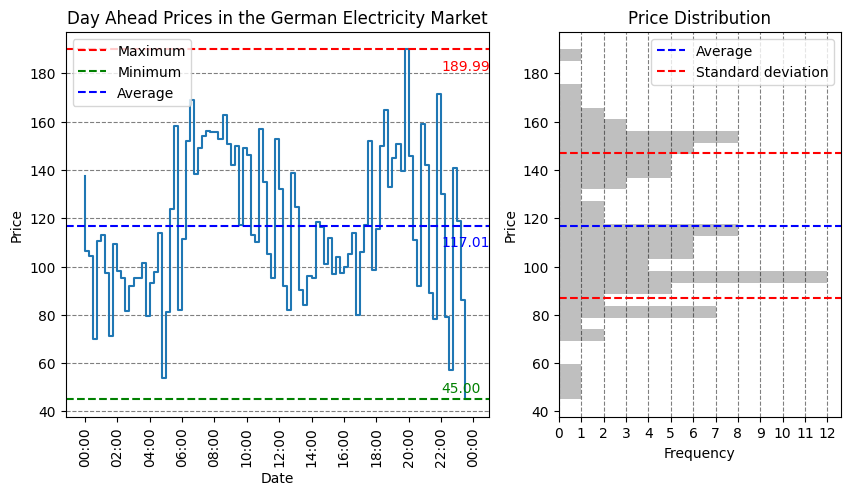

In [117]:
from utils import plot_electricity_prices

plot_electricity_prices(prices)

**Task description:** Resample the prices to hourly values using ``df.resample('1H').mean()`` and then plot the prices again.

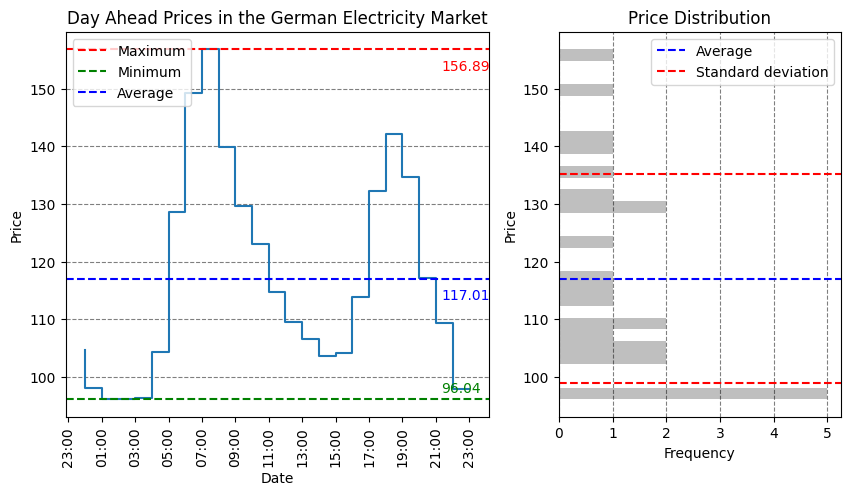

In [118]:
prices = ...
plot_electricity_prices(prices)

We are also including the data for the pv production.

In [119]:
parent_folder = pathlib.Path.cwd().parents[1] / "datasets" / "mes" / "exercise_3" / "data"
file_path = parent_folder / "Timeseries_50.763_6.081_SA2_1kWp_crystSi_14_41deg_-2deg_2020_2020.json"

import json

# Load the JSON data
with open(file_path, 'r') as f:
    data = json.load(f)

# Extract the P values for each hour
hourly_data = data['outputs']['hourly']
P_values = np.array([hour['P'] for hour in hourly_data]) / 1000

#Unfortunately, 2020 was a leap year, so we need to remove the additional day, so find the index of February 29th in the array
feb_29_index = 24 * (31 + 28) # Index of the last hour of Feb 28th

# Remove the data associated with February 29th from the array
P_values = np.delete(P_values, range(feb_29_index, feb_29_index + 24))

# Convert the hourly power output data into a Pandas series
pv_series = pd.Series(P_values, index=pd.date_range(start="01-01-2023 00:00", end="31-12-2023 23:00", freq='H'))
pv_feed_in = pv_series.loc[prices.index]

**Task description:** Determine the maximum pv output power for the given time period.

0.1963

Let us plot the data for inspection.

Text(0.5, 1.0, 'PV Feed over Time')

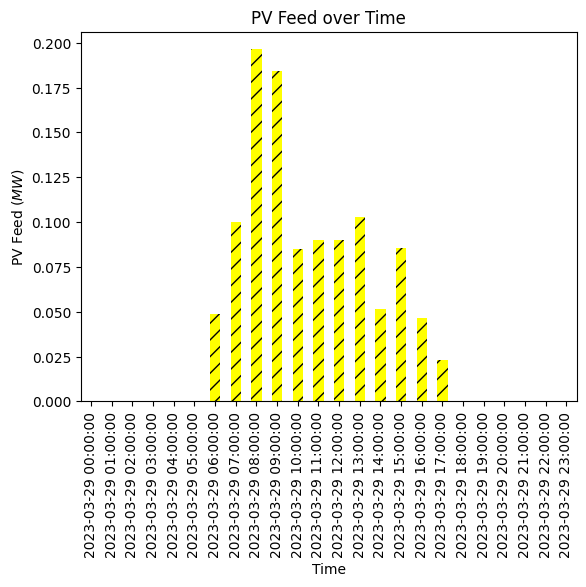

In [121]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot the PV feed as a bar chart with stripes
ax = pv_feed_in.plot.bar(color='yellow', hatch='//')

# Add labels and title to the plot
ax.set_xlabel('Time')
ax.set_ylabel('PV Feed ($MW$)')
ax.set_title('PV Feed over Time')

We are also including data for the wind production.

In [122]:
parent_folder = pathlib.Path.cwd().parents[1] / "datasets" / "mes" / "exercise_4" / "data"
file_path = parent_folder / "wind_power_output.csv"

wind_feed_in = pd.read_csv(file_path, index_col=[0], parse_dates=True) / 1000 / 1000
wind_feed_in = wind_feed_in["feedin_power_plant"].loc[prices.index]

**Task description:** Determine the maximum wind power output.

0.9698324321961497

Again, we can plot the values.

Text(0.5, 1.0, 'Wind Feed over Time')

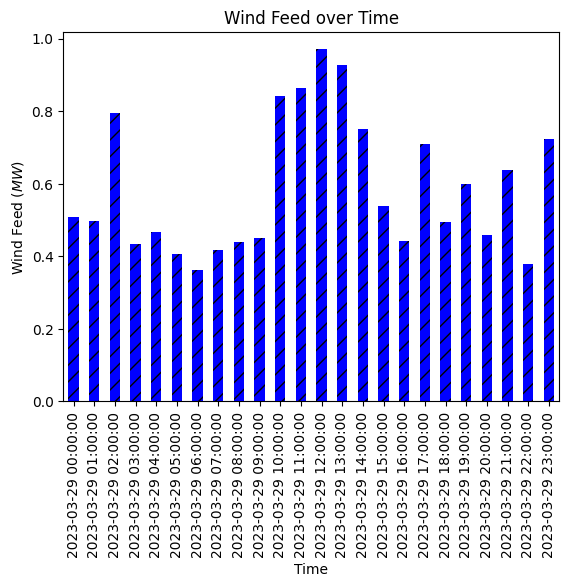

In [124]:
import matplotlib.pyplot as plt

# Assuming your pandas series is named 'prices'
fig, ax = plt.subplots()

# Plot the PV feed as a bar chart with blue stripes
ax = wind_feed_in.plot.bar(color='blue', hatch='//')

# Add labels and title to the plot
ax.set_xlabel('Time')
ax.set_ylabel('Wind Feed ($MW$)')
ax.set_title('Wind Feed over Time')

### Task 4.15 : Create multi-period optimization problem for optimal dispatch of power plants

**Task description:** Create a new Pyomo model called ``vpp_time_variant``.

In [125]:
# Create the Pyomo model


**Task description:** Add new sets for all power plants ``P``, for the non-dispatchables ``ND`` and for the 24 hours ``H``, over which we would like to optimise. Furthermore add the new variables as time-variant now using ``pyo.Var()``.

**Task description:** Consider the output power now as time variant for the renewables, write to the dictionary ``c`` the new Pandas Series for the PV Plant and also the wind turbine, convert the Series into an array for more convenience using ``series.to_numpy()``.

**Task description:** Add the new constraints for the renewables for all time steps in ``H``.

**Bonus task description:** Add the constraints that renewables will always produce at their full output power.

**Task description:** Create a variable called ``c_rev`` and store the day ahead prices from the variable ``prices`` in their using again ``series.to_numpy()``.

Due to a shortage in fuel supply, the prices for the CHP plant have dramatically increased and have now risen to $120€/MWh$.

In [131]:
o["chp_plant"] = 120

**Task description:** Write the new objective function using now time variant prices and output power.

**Task description:** Update the model and optimize. Compare with the former values.

We can now display and plot the optimized values that can be extracted from the model using ``pyo.value(model.y[p,h])``, where y is the optimization variable as given above. We then transfer the individual optimized values per power plant to a dictionary and use it for plotting.

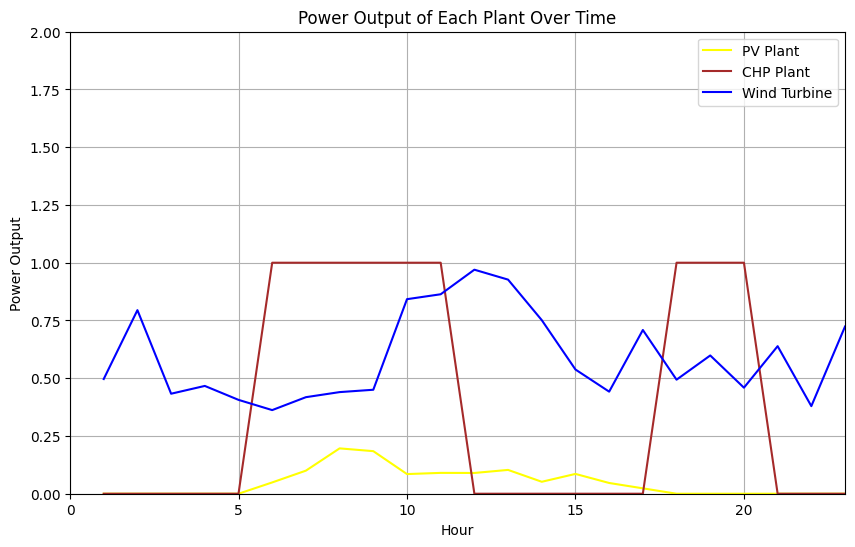

In [134]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# You need to use value function in Pyomo to get the variable values
y_sol = {(p,h): pyo.value(model.y[p,h]) for p in model.P for h in model.H}

# Initialize an empty dictionary for each power plant
pv_plant_values = {}
chp_plant_values = {}
wind_turbine_values = {}

# Store the variable values in the corresponding dictionary
for p in model.P:
    for h in model.H:
        if p == "pv_plant":
            pv_plant_values[h] = y_sol[p, h]
        elif p == "chp_plant":
            chp_plant_values[h] = y_sol[p, h]
        elif p == "wind_turbine":
            wind_turbine_values[h] = y_sol[p, h]

# Plot the values
plt.figure(figsize=(10, 6))

plt.plot(list(pv_plant_values.keys()), list(pv_plant_values.values()), label='PV Plant', color="yellow")
plt.plot(list(chp_plant_values.keys()), list(chp_plant_values.values()), label='CHP Plant', color="brown")
plt.plot(list(wind_turbine_values.keys()), list(wind_turbine_values.values()), label='Wind Turbine', color="blue")

plt.xlim(0, 23)
plt.ylim(0, 2)

# Add a title
plt.title('Power Output of Each Plant Over Time')

# Add a grid
plt.grid(True)

plt.xlabel('Hour')
plt.ylabel('Power Output')
plt.legend()

plt.show()
